# Laptop Price Prediction 

Predicting the price of a laptop given certain features about the product like RAM, GPU, weight etc 

Goal is the find approximate price range of a laptop based on given dataset which may be listed in ecommerce websites like Amazon, Flipkart etc..

In [1]:
# importing all basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# other required ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import tree

In [2]:
# importing the dataset 

df = pd.read_csv('laptop_data.csv', index_col=0)
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   71378.6832  
1        Intel HD Graphics 6000  macOS  1.34kg   47895.5232  
2         Intel HD Graphics 620  No OS  1.86kg   30636.0000  
3            AMD Radeon Pro 455  macOS  1.83kg  135195.3360  
4  Intel Iris Plus Graphics 650  macOS  1.37kg   96095.8080

## Exploratory Data Analysis and Feature Engineering

In [3]:
# to know the structure of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


The data contains 

* 1303 records
* Two numeric columns and 8 string based columns 

In [4]:
# checking missing values 

df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

> There are no missing values in the dataset

In [5]:
# checking duplicated records 

df.duplicated().sum()

29

In [6]:
# dropping duplicate records

df.drop_duplicates(inplace=True)

df.shape

(1274, 11)

In [7]:
# Separating categorical and numerical features

cat_vars = df.select_dtypes(include=['object']).columns
num_vars = df.select_dtypes(exclude=['object']).columns

print(cat_vars)
print(num_vars)

Index(['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory',
       'Gpu', 'OpSys', 'Weight'],
      dtype='object')
Index(['Inches', 'Price'], dtype='object')


In [8]:
# fetching unique values in columns

def unique_values(col):
    print(f"The unique values in '{col}' are: {df[col].unique()}")
    
for col in df.columns:
    unique_values(col)
    print("-"*100)

The unique values in 'Company' are: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
----------------------------------------------------------------------------------------------------
The unique values in 'TypeName' are: ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
----------------------------------------------------------------------------------------------------
The unique values in 'Inches' are: [13.3 15.6 15.4 14.  12.  11.6 17.3 10.1 13.5 12.5 13.  18.4 13.9 12.3
 17.  15.  14.1 11.3]
----------------------------------------------------------------------------------------------------
The unique values in 'ScreenResolution' are: ['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / To

**Inference from above result:**
    
Most of columns have quite lot of textual data in it which required good amount of preprocessing to acquire best results.

In [9]:
"""
cleaning the text data as below 
Replacing the 'GB' with empty string so we can treat it as integer value in RAM and Memory feature
Also, in Weight column, removing Kg will help us to treat it as float value
"""

df['Ram'] = df['Ram'].str.replace('GB','').astype('int32')
df['Weight'] = df['Weight'].str.replace('kg','').astype('float32')

df.head()


Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832  
1        Intel HD Graphics 6000  macOS    1.34   47895.5232  
2         Intel HD Graphics 620  No OS    1.86   30636.0000  
3            AMD Radeon Pro 455  macOS    1.83  135195.3360  
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 0 to 1273
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1274 non-null   object 
 1   TypeName          1274 non-null   object 
 2   Inches            1274 non-null   float64
 3   ScreenResolution  1274 non-null   object 
 4   Cpu               1274 non-null   object 
 5   Ram               1274 non-null   int32  
 6   Memory            1274 non-null   object 
 7   Gpu               1274 non-null   object 
 8   OpSys             1274 non-null   object 
 9   Weight            1274 non-null   float32
 10  Price             1274 non-null   float64
dtypes: float32(1), float64(2), int32(1), object(7)
memory usage: 109.5+ KB


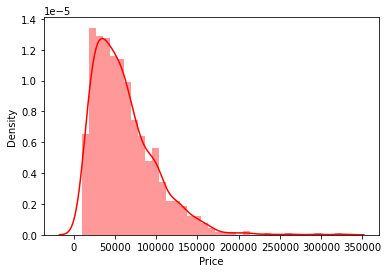

In [11]:
# Distribution of target variable 

sns.distplot(df['Price'], color='red');

In [12]:
df['Price'].describe()

count      1274.000000
mean      60503.185074
std       37333.222977
min        9270.720000
25%       32495.605200
50%       52693.920000
75%       79773.480000
max      324954.720000
Name: Price, dtype: float64

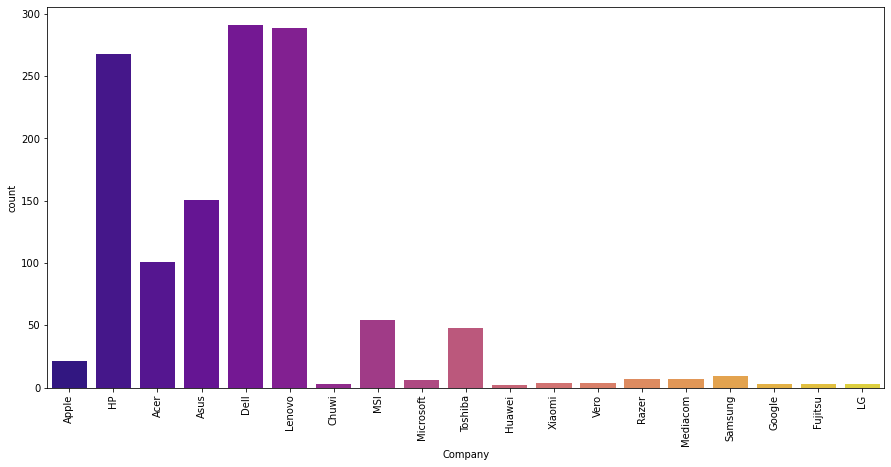

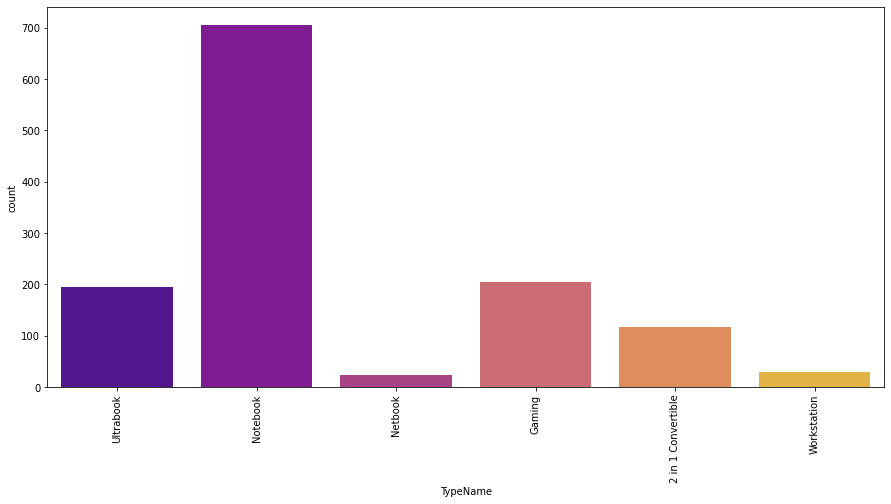

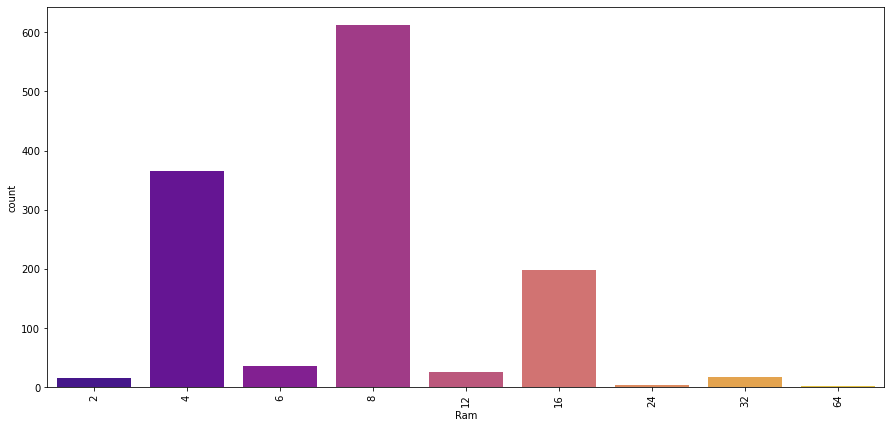

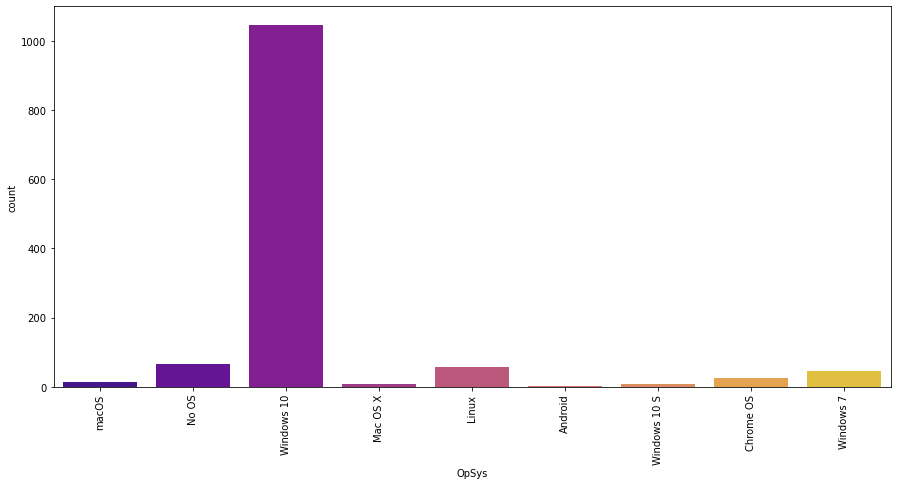

In [13]:
# plotting count plots of categorical variables 

def draw_count_plot(col):
    plt.figure(figsize=(15,7))
    sns.countplot(df[col], palette='plasma')
    plt.xticks(rotation='vertical') # xlabels to be vertical
    
to_view = ['Company', 'TypeName', 'Ram', 'OpSys']

for col in to_view:
    draw_count_plot(col)

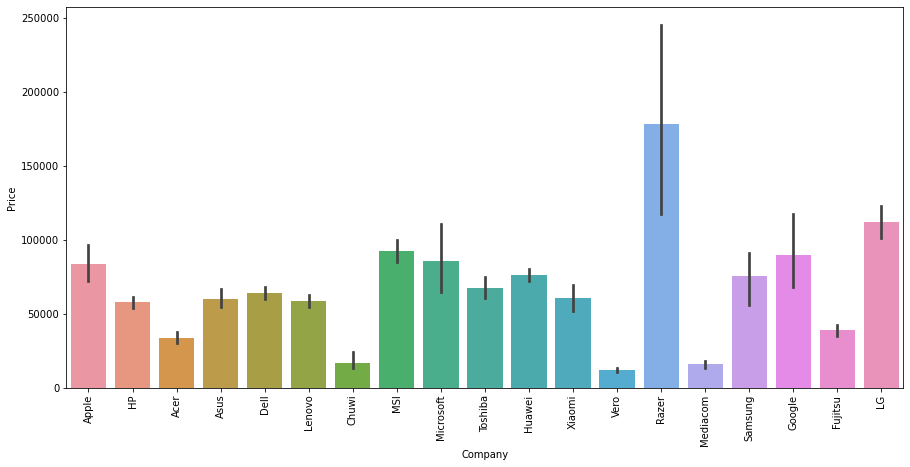

In [14]:
# Average price of the laptop based on brand 

plt.figure(figsize=(15,7))
sns.barplot(x='Company', y='Price', data=df, ci=95) # black lines indicates 95% CI
plt.xticks(rotation='vertical')
plt.show()

In [15]:
df['TypeName'].value_counts()

Notebook              706
Gaming                205
Ultrabook             194
2 in 1 Convertible    117
Workstation            29
Netbook                23
Name: TypeName, dtype: int64

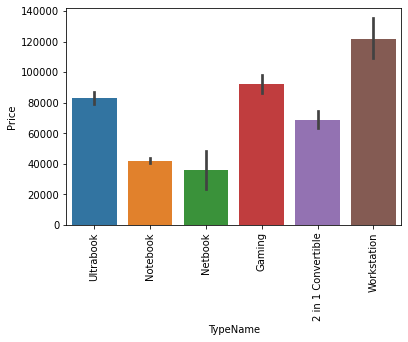

In [16]:
# laptop type and variation in price

sns.barplot(x='TypeName', y='Price', data=df, ci=95) # black lines indicates 95% CI
plt.xticks(rotation='vertical')
plt.show()

> The variation in notebook is smaller because it is most widely used by any customer in World, so the variation in price 
is lesser comapred to others 

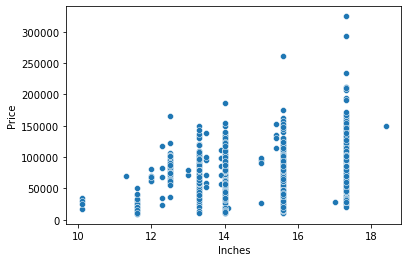

In [17]:
# comparison of inches with Price 

sns.scatterplot('Inches', 'Price', data=df);

From above graph, we can infer that 

* 17 inches laptop are higher price laptop than others
* Most of users buy laptop with inches between 12 and 15, where most of data are accummulated 
* The cheaper laptops are smaller in size

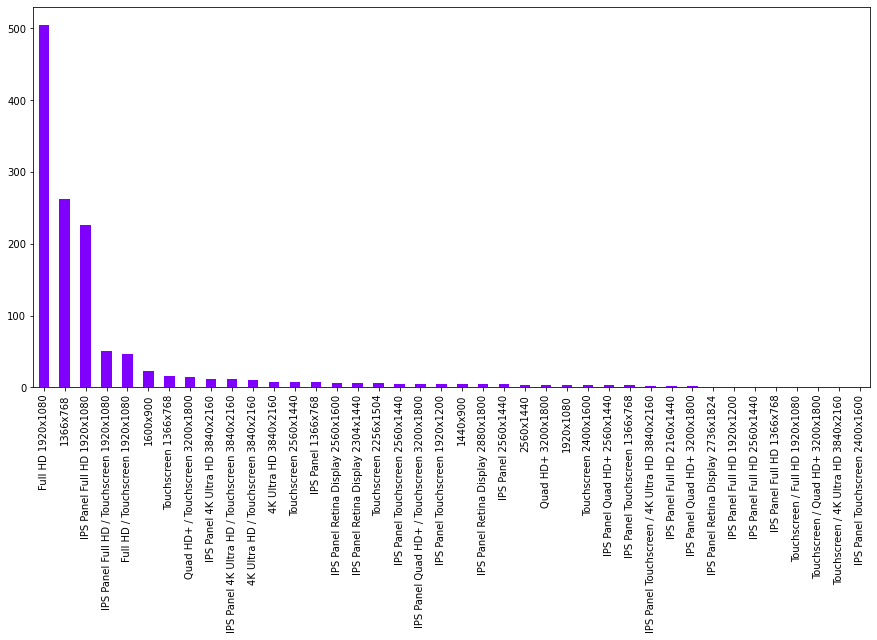

In [18]:
# checking the different types of screen resolution types

plt.figure(figsize=(15,7))
df['ScreenResolution'].value_counts().plot(kind='bar', cmap='rainbow')
plt.show()

In [19]:
df['ScreenResolution'].value_counts()

Full HD 1920x1080                                505
1366x768                                         262
IPS Panel Full HD 1920x1080                      226
IPS Panel Full HD / Touchscreen 1920x1080         51
Full HD / Touchscreen 1920x1080                   47
1600x900                                          23
Touchscreen 1366x768                              16
Quad HD+ / Touchscreen 3200x1800                  15
IPS Panel 4K Ultra HD 3840x2160                   12
IPS Panel 4K Ultra HD / Touchscreen 3840x2160     11
4K Ultra HD / Touchscreen 3840x2160               10
4K Ultra HD 3840x2160                              7
Touchscreen 2560x1440                              7
IPS Panel 1366x768                                 7
IPS Panel Retina Display 2560x1600                 6
IPS Panel Retina Display 2304x1440                 6
Touchscreen 2256x1504                              6
IPS Panel Touchscreen 2560x1440                    5
IPS Panel Quad HD+ / Touchscreen 3200x1800    

> We could observe that there are lot of screen resolution types which have touch screen or IPS panel in it, so better creating a new variables like touch screen, IPS panel etc.. to break this feature into new features. 

**Working with Screen Resolution feature**

In [20]:
# creating new variable called touch screen with values 1 and 0

df['TouchScreen'] = df['ScreenResolution'].apply(lambda ele :1 if 'Touchscreen' in ele else 0)

df

Company            TypeName  Inches  \
0         Apple           Ultrabook    13.3   
1         Apple           Ultrabook    13.3   
2            HP            Notebook    15.6   
3         Apple           Ultrabook    15.4   
4         Apple           Ultrabook    13.3   
5          Acer            Notebook    15.6   
6         Apple           Ultrabook    15.4   
7         Apple           Ultrabook    13.3   
8          Asus           Ultrabook    14.0   
9          Acer           Ultrabook    14.0   
10           HP            Notebook    15.6   
11           HP            Notebook    15.6   
12        Apple           Ultrabook    15.4   
13         Dell            Notebook    15.6   
14        Apple           Ultrabook    12.0   
15        Apple           Ultrabook    13.3   
16         Dell            Notebook    15.6   
17        Apple           Ultrabook    15.4   
18       Lenovo            Notebook    15.6   
19         Dell           Ultrabook    13.3   
20         Asus             Netbook    11.6   
21       Lenovo              Gaming    15.6   
22           HP            Notebook    15.6   
23         Dell  2 in 1 Convertible    13.3   
24           HP           Ultrabook    15.6   
25         Dell            Notebook    15.6   
26        Apple           Ultrabook    13.3   
27         Dell            Notebook    15.6   
28         Dell           Ultrabook    15.6   
29           HP            Notebook    17.3   
30        Chuwi            Notebook    15.6   
31         Asus            Notebook    14.0   
32           HP            Notebook    17.3   
33         Dell           Ultrabook    13.3   
34        Apple           Ultrabook    13.3   
35       Lenovo            Notebook    14.0   
36         Acer            Notebook    15.6   
37         Dell            Notebook    17.3   
38           HP            Notebook    15.6   
39           HP            Notebook    15.6   
40         Asus            Notebook    15.6   
41         Dell              Gaming    15.6   
42         Asus            Notebook    15.6   
43         Acer            Notebook    15.6   
44         Dell  2 in 1 Convertible    17.3   
45        Apple           Ultrabook    13.3   
46       Lenovo            Notebook    15.6   
47         Asus              Gaming    17.3   
48         Dell            Notebook    15.6   
49         Asus            Notebook    17.3   
50       Lenovo  2 in 1 Convertible    10.1   
51         Acer            Notebook    15.6   
52           HP            Notebook    15.6   
53           HP            Notebook    13.3   
54         Acer            Notebook    15.6   
55         Dell            Notebook    15.6   
56           HP            Notebook    15.6   
57         Asus            Notebook    15.6   
58          MSI              Gaming    17.3   
59         Asus            Notebook    15.6   
60         Dell            Notebook    17.3   
61         Dell           Ultrabook    14.0   
62       Lenovo            Notebook    14.0   
63         Asus            Notebook    14.0   
64           HP            Notebook    15.6   
65         Asus           Ultrabook    15.6   
66           HP            Notebook    15.6   
67           HP            Notebook    14.0   
68       Lenovo            Notebook    15.6   
69         Asus              Gaming    17.3   
70    Microsoft           Ultrabook    13.5   
71         Dell           Ultrabook    13.3   
72         Dell            Notebook    15.6   
73          MSI              Gaming    17.3   
74         Acer            Notebook    14.0   
75         Asus              Gaming    15.6   
76       Lenovo            Notebook    15.6   
77         Dell            Notebook    15.6   
78         Acer            Notebook    15.6   
79           HP            Notebook    17.3   
80         Dell           Ultrabook    15.6   
81        Apple           Ultrabook    12.0   
82           HP            Notebook    14.0   
83       Lenovo            Notebook    15.6   
84         Ac

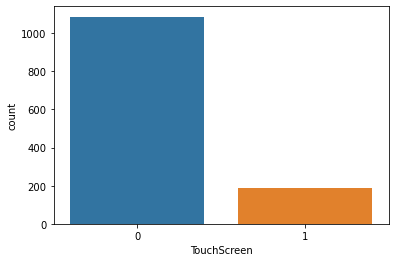

In [21]:
sns.countplot(df['TouchScreen']);

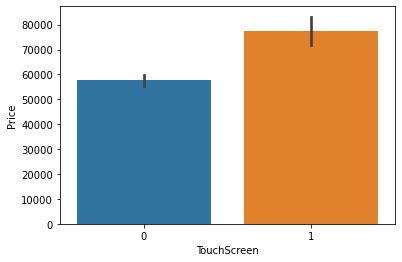

In [22]:
# comparison of touch screen with price

sns.barplot('TouchScreen', 'Price', data=df);

*The above graph indicates, price of laptop is higher if it is touch screen and converse*

In [23]:
# creating another variable for IPS panel

df['IPS'] = df['ScreenResolution'].apply(lambda ele :1 if 'IPS' in ele else 0)

df.sample(5)

Company   TypeName  Inches                           ScreenResolution  \
1181  Lenovo  Ultrabook    15.6                          Full HD 1920x1080   
214   Huawei  Ultrabook    13.0                IPS Panel Full HD 2160x1440   
1074  Lenovo  Ultrabook    12.5  IPS Panel Full HD / Touchscreen 1920x1080   
137     Asus     Gaming    17.3                          Full HD 1920x1080   
1267    Dell   Notebook    15.6                                   1366x768   

                              Cpu  Ram                Memory  \
1181   Intel Core i7 7500U 2.7GHz    6             256GB SSD   
214    Intel Core i7 7500U 2.7GHz    8             512GB SSD   
1074   Intel Core i7 6500U 2.5GHz    8             256GB SSD   
137   Intel Core i5 7300HQ 2.5GHz    8  128GB SSD +  1TB HDD   
1267   Intel Core i7 7500U 2.7GHz    8               1TB HDD   

                          Gpu       OpSys  Weight       Price  TouchScreen  \
1181      Nvidia GeForce 920M  Windows 10    1.54  44275.6800            0   
214     Intel HD Graphics 620  Windows 10    1.05  79866.7200            0   
1074    Intel HD Graphics 520  Windows 10    1.30  91294.7472            1   
137   Nvidia GeForce GTX 1050  Windows 10    3.00  49976.6400            0   
1267       AMD Radeon R5 M430       Linux    2.30  42943.1472            0   

      IPS  
1181    0  
214     1  
1074    1  
137     0  
1267    0

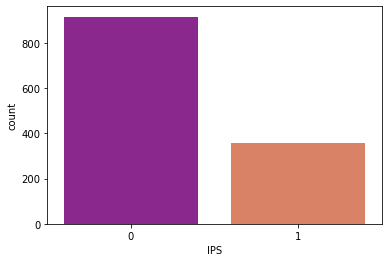

In [24]:
sns.countplot(df['IPS'], palette='plasma');

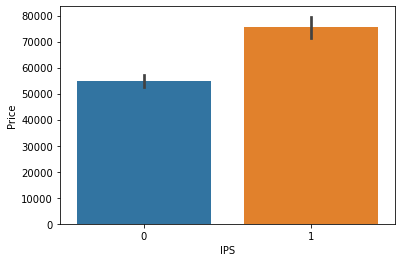

In [25]:
# comparison of touch screen with price

sns.barplot('IPS', 'Price', data=df);

**Next step:**

It is clear in the data that, each unique value of Screen resolution has width and height of pixel value in it, 
next step is to extract the resolution size from the data.

In [26]:
splitdf = df['ScreenResolution'].str.split('x', n=1, expand=True) # expand gives result in a df
splitdf.head()

# take the x resolution
df['X_res'] = splitdf[0]
df['Y_res'] = splitdf[1]

df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

                           X_res Y_res  
0  IPS Panel Retina Display 2560  1600  
1                           1440   900  
2                   Full HD 1920  1080  
3  IPS Panel Retina Display 2880  1800  
4  IPS Panel Retina Display 2560  1600

In [27]:
# extracting only X resolution from chunk of text in X_res column using regex

# extracting only the pixel values (last 4 digits) and few records has comma in it, so removing them
df['X_res'] = df['X_res'].str.replace(',','').str.findall(r'(\d+\d)').apply(lambda x:x[0])
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

  X_res Y_res  
0  2560  1600  
1  1440   900  
2  1920  1080  
3  2880  1800  
4  2560  1600

In [28]:
df['X_res'] = df['X_res'].astype('int32')
df['Y_res'] = df['Y_res'].astype('int32')

**Note:**
    
Screen resolution feature has been splitted into 4 different new features which may or may not give better understanding 
of the target variable, trial and error method applicable here  

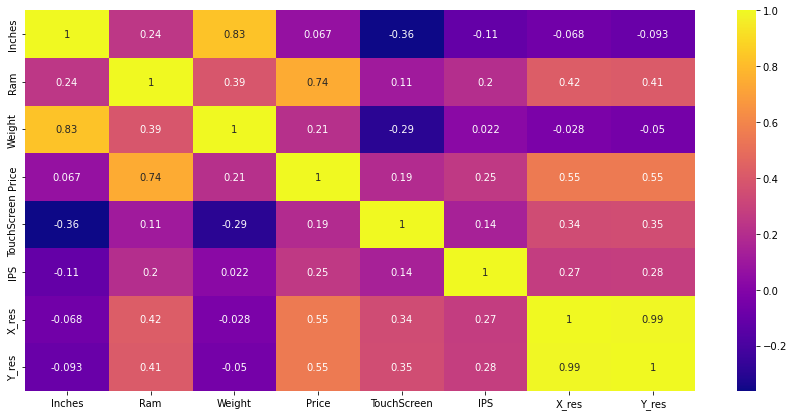

In [29]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, cmap='plasma');

> From above matrix, it is known that there is high correlation between X resolution and Y resolution as both are single variable splitted into two halves 

In [30]:
df.corr()['Price']

Inches         0.066990
Ram            0.740106
Weight         0.212192
Price          1.000000
TouchScreen    0.188631
IPS            0.250358
X_res          0.552074
Y_res          0.548111
Name: Price, dtype: float64

**From correlation values, both X_res and Y_res has positive relation with Price variable. So that's why we have splitted the variable into two. when X_res and Y_res increases, Price also increases and same is with Ram variable.**

**But there could be a problem of collinearity with resolution, so we will try to combine resolution with inches to create a new variable `PPI{Pixels per inch}` using formula instead of dropping one feature. here the domain knowledge about laptop comes into play.**



In [31]:
df['PPI'] = (((df['X_res'] ** 2 + df['Y_res'] ** 2) ** 0.5) / (df['Inches'])).astype('float32')
df.head()

Company   TypeName  Inches                    ScreenResolution  \
0   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook    13.3                            1440x900   
2      HP   Notebook    15.6                   Full HD 1920x1080   
3   Apple  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

   X_res  Y_res         PPI  
0   2560   1600  226.983002  
1   1440    900  127.677940  
2   1920   1080  141.212006  
3   2880   1800  220.534622  
4   2560   1600  226.983002

In [32]:
# Now we will look into correlation matrix 

df.corr()['Price']

Inches         0.066990
Ram            0.740106
Weight         0.212192
Price          1.000000
TouchScreen    0.188631
IPS            0.250358
X_res          0.552074
Y_res          0.548111
PPI            0.469539
Name: Price, dtype: float64

> Now it is evident, combination of inches, X_res, Y_res gives good amount of correlation with target varaible Price, so we can drop all three variables.

In [33]:
df.drop(['Inches', 'X_res', 'Y_res'], axis=1, inplace=True)
df.head()

Company   TypeName                    ScreenResolution  \
0   Apple  Ultrabook  IPS Panel Retina Display 2560x1600   
1   Apple  Ultrabook                            1440x900   
2      HP   Notebook                   Full HD 1920x1080   
3   Apple  Ultrabook  IPS Panel Retina Display 2880x1800   
4   Apple  Ultrabook  IPS Panel Retina Display 2560x1600   

                          Cpu  Ram               Memory  \
0        Intel Core i5 2.3GHz    8            128GB SSD   
1        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3        Intel Core i7 2.7GHz   16            512GB SSD   
4        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

          PPI  
0  226.983002  
1  127.677940  
2  141.212006  
3  220.534622  
4  226.983002

In [34]:
# remove the base feature Screen Resolution 

df.drop(['ScreenResolution'], axis=1, inplace=True)
df.head()

Company   TypeName                         Cpu  Ram               Memory  \
0   Apple  Ultrabook        Intel Core i5 2.3GHz    8            128GB SSD   
1   Apple  Ultrabook        Intel Core i5 1.8GHz    8  128GB Flash Storage   
2      HP   Notebook  Intel Core i5 7200U 2.5GHz    8            256GB SSD   
3   Apple  Ultrabook        Intel Core i7 2.7GHz   16            512GB SSD   
4   Apple  Ultrabook        Intel Core i5 3.1GHz    8            256GB SSD   

                            Gpu  OpSys  Weight        Price  TouchScreen  IPS  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832            0    1   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232            0    0   
2         Intel HD Graphics 620  No OS    1.86   30636.0000            0    0   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360            0    1   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080            0    1   

          PPI  
0  226.983002  
1  127.677940  
2  141.212006  
3  220.534622  
4  226.983002

**Conclusion about Screen Resolution feature:**
    
The feature is finally divided into three columns which are Touch Screen, IPS panel availability and 
Pixel per inches

*Next we will focus on CPU column*

In [35]:
df['Cpu'].value_counts()

Intel Core i5 7200U 2.5GHz               190
Intel Core i7 7700HQ 2.8GHz              146
Intel Core i7 7500U 2.7GHz               132
Intel Core i7 8550U 1.8GHz                73
Intel Core i5 8250U 1.6GHz                72
Intel Core i5 6200U 2.3GHz                68
Intel Core i3 6006U 2GHz                  64
Intel Core i7 6500U 2.5GHz                41
Intel Core i7 6700HQ 2.6GHz               41
Intel Core i3 7100U 2.4GHz                35
Intel Core i5 7300HQ 2.5GHz               33
Intel Celeron Dual Core N3350 1.1GHz      30
Intel Celeron Dual Core N3060 1.6GHz      24
Intel Core i7 6600U 2.6GHz                18
Intel Core i3 6006U 2.0GHz                16
Intel Core i5 7300U 2.6GHz                14
Intel Pentium Quad Core N4200 1.1GHz      14
Intel Core i7 7600U 2.8GHz                13
Intel Pentium Quad Core N3710 1.6GHz      11
Intel Core i5 6300U 2.4GHz                11
AMD A9-Series 9420 3GHz                   11
Intel Core i7 6820HK 2.7GHz               10
Intel Core

**In this column, we will consider first three words like Intel core i5 and consider other Intel variations as 'Other' category and also AMD is other separate category. We will neglect clock speed and frequency as of now**

**So we observe that first three words gives the type of CPU, so we will extract those first** 

In [36]:
df['CPU_name'] = df['Cpu'].apply(lambda x: " ".join(x.split()[:3]))
df

Company            TypeName                                    Cpu  \
0         Apple           Ultrabook                   Intel Core i5 2.3GHz   
1         Apple           Ultrabook                   Intel Core i5 1.8GHz   
2            HP            Notebook             Intel Core i5 7200U 2.5GHz   
3         Apple           Ultrabook                   Intel Core i7 2.7GHz   
4         Apple           Ultrabook                   Intel Core i5 3.1GHz   
5          Acer            Notebook                AMD A9-Series 9420 3GHz   
6         Apple           Ultrabook                   Intel Core i7 2.2GHz   
7         Apple           Ultrabook                   Intel Core i5 1.8GHz   
8          Asus           Ultrabook             Intel Core i7 8550U 1.8GHz   
9          Acer           Ultrabook             Intel Core i5 8250U 1.6GHz   
10           HP            Notebook             Intel Core i5 7200U 2.5GHz   
11           HP            Notebook               Intel Core i3 6006U 2GHz   
12        Apple           Ultrabook                   Intel Core i7 2.8GHz   
13         Dell            Notebook               Intel Core i3 6006U 2GHz   
14        Apple           Ultrabook                 Intel Core M m3 1.2GHz   
15        Apple           Ultrabook                   Intel Core i5 2.3GHz   
16         Dell            Notebook             Intel Core i7 7500U 2.7GHz   
17        Apple           Ultrabook                   Intel Core i7 2.9GHz   
18       Lenovo            Notebook             Intel Core i3 7100U 2.4GHz   
19         Dell           Ultrabook             Intel Core i5 8250U 1.6GHz   
20         Asus             Netbook            Intel Atom x5-Z8350 1.44GHz   
21       Lenovo              Gaming            Intel Core i5 7300HQ 2.5GHz   
22           HP            Notebook           AMD E-Series E2-9000e 1.5GHz   
23         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
24           HP           Ultrabook             Intel Core i7 8550U 1.8GHz   
25         Dell            Notebook               Intel Core i3 6006U 2GHz   
26        Apple           Ultrabook                   Intel Core i5 1.6GHz   
27         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
28         Dell           Ultrabook             Intel Core i7 8650U 1.9GHz   
29           HP            Notebook             Intel Core i5 8250U 1.6GHz   
30        Chuwi            Notebook            Intel Atom x5-Z8300 1.44GHz   
31         Asus            Notebook            AMD E-Series E2-6110 1.5GHz   
32           HP            Notebook              AMD A6-Series 9220 2.5GHz   
33         Dell           Ultrabook             Intel Core i7 8550U 1.8GHz   
34        Apple           Ultrabook                   Intel Core i5 1.6GHz   
35       Lenovo            Notebook   Intel Celeron Dual Core N3350 1.1GHz   
36         Acer            Notebook             Intel Core i3 7130U 2.7GHz   
37         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
38           HP            Notebook             Intel Core i5 7200U 2.5GHz   
39           HP            Notebook             Intel Core i5 8250U 1.6GHz   
40         Asus            Notebook               Intel Core i3 6006U 2GHz   
41         Dell              Gaming            Intel Core i7 7700HQ 2.8GHz   
42         Asus            Notebook             Intel Core i5 7200U 2.5GHz   
43         Acer            Notebook             Intel Core i5 8250U 1.6GHz   
44         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
45        Apple           Ultrabook                   Intel Core i5 2.0GHz   
46       Lenovo            Notebook               Intel Core i3 6006U 2GHz   
47         Asus              Gaming                    AMD Ryzen 1700 3GHz   
48         Dell            Notebook             Intel Core i5 7200U 2.5GHz   
49         Asus            Notebook   Intel Pentium Quad Core N4200 1.1GHz   
50       Lenovo  2 in 1 Conver

In [37]:
"""
Function which gives out Intel variants as it is when the input is i3, i5, or i7..
if it is other intel variants, return other intel and return AMD processor for other different
variants
"""

def preprocessortype(text):
    # reducing into three categories
    
    if text in ['Intel Core i7', 'Intel Core i5', 'Intel Core i3']:
        return text
    else:
        if text.split()[0] == 'Intel':
            return "Other Intel Processor"
        else:
            return "AMD Processor"
        
df['CPU_name']  = df['CPU_name'].apply(lambda text: preprocessortype(text))
df


Company            TypeName                                    Cpu  \
0         Apple           Ultrabook                   Intel Core i5 2.3GHz   
1         Apple           Ultrabook                   Intel Core i5 1.8GHz   
2            HP            Notebook             Intel Core i5 7200U 2.5GHz   
3         Apple           Ultrabook                   Intel Core i7 2.7GHz   
4         Apple           Ultrabook                   Intel Core i5 3.1GHz   
5          Acer            Notebook                AMD A9-Series 9420 3GHz   
6         Apple           Ultrabook                   Intel Core i7 2.2GHz   
7         Apple           Ultrabook                   Intel Core i5 1.8GHz   
8          Asus           Ultrabook             Intel Core i7 8550U 1.8GHz   
9          Acer           Ultrabook             Intel Core i5 8250U 1.6GHz   
10           HP            Notebook             Intel Core i5 7200U 2.5GHz   
11           HP            Notebook               Intel Core i3 6006U 2GHz   
12        Apple           Ultrabook                   Intel Core i7 2.8GHz   
13         Dell            Notebook               Intel Core i3 6006U 2GHz   
14        Apple           Ultrabook                 Intel Core M m3 1.2GHz   
15        Apple           Ultrabook                   Intel Core i5 2.3GHz   
16         Dell            Notebook             Intel Core i7 7500U 2.7GHz   
17        Apple           Ultrabook                   Intel Core i7 2.9GHz   
18       Lenovo            Notebook             Intel Core i3 7100U 2.4GHz   
19         Dell           Ultrabook             Intel Core i5 8250U 1.6GHz   
20         Asus             Netbook            Intel Atom x5-Z8350 1.44GHz   
21       Lenovo              Gaming            Intel Core i5 7300HQ 2.5GHz   
22           HP            Notebook           AMD E-Series E2-9000e 1.5GHz   
23         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
24           HP           Ultrabook             Intel Core i7 8550U 1.8GHz   
25         Dell            Notebook               Intel Core i3 6006U 2GHz   
26        Apple           Ultrabook                   Intel Core i5 1.6GHz   
27         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
28         Dell           Ultrabook             Intel Core i7 8650U 1.9GHz   
29           HP            Notebook             Intel Core i5 8250U 1.6GHz   
30        Chuwi            Notebook            Intel Atom x5-Z8300 1.44GHz   
31         Asus            Notebook            AMD E-Series E2-6110 1.5GHz   
32           HP            Notebook              AMD A6-Series 9220 2.5GHz   
33         Dell           Ultrabook             Intel Core i7 8550U 1.8GHz   
34        Apple           Ultrabook                   Intel Core i5 1.6GHz   
35       Lenovo            Notebook   Intel Celeron Dual Core N3350 1.1GHz   
36         Acer            Notebook             Intel Core i3 7130U 2.7GHz   
37         Dell            Notebook             Intel Core i5 8250U 1.6GHz   
38           HP            Notebook             Intel Core i5 7200U 2.5GHz   
39           HP            Notebook             Intel Core i5 8250U 1.6GHz   
40         Asus            Notebook               Intel Core i3 6006U 2GHz   
41         Dell              Gaming            Intel Core i7 7700HQ 2.8GHz   
42         Asus            Notebook             Intel Core i5 7200U 2.5GHz   
43         Acer            Notebook             Intel Core i5 8250U 1.6GHz   
44         Dell  2 in 1 Convertible             Intel Core i5 8250U 1.6GHz   
45        Apple           Ultrabook                   Intel Core i5 2.0GHz   
46       Lenovo            Notebook               Intel Core i3 6006U 2GHz   
47         Asus              Gaming                    AMD Ryzen 1700 3GHz   
48         Dell            Notebook             Intel Core i5 7200U 2.5GHz   
49         Asus            Notebook   Intel Pentium Quad Core N4200 1.1GHz   
50       Lenovo  2 in 1 Conver

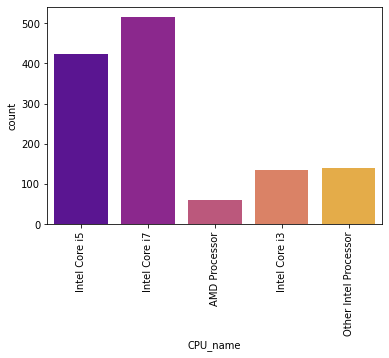

In [38]:
sns.countplot(df['CPU_name'], palette='plasma')
plt.xticks(rotation='vertical');

**So, we have reduced different type of CPU processors into 5 categories**

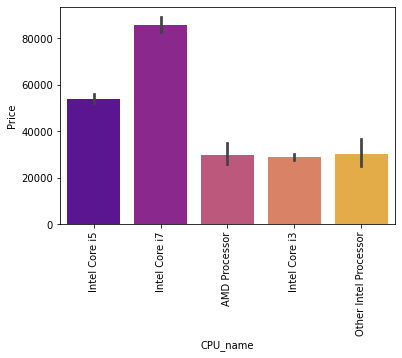

In [39]:
# comparison of new column with Price

sns.barplot(df['CPU_name'], df['Price'],palette='plasma')
plt.xticks(rotation='vertical');

In [40]:
# dropping CPU column 

df.drop(['Cpu'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram               Memory                           Gpu  \
0   Apple  Ultrabook    8            128GB SSD  Intel Iris Plus Graphics 640   
1   Apple  Ultrabook    8  128GB Flash Storage        Intel HD Graphics 6000   
2      HP   Notebook    8            256GB SSD         Intel HD Graphics 620   
3   Apple  Ultrabook   16            512GB SSD            AMD Radeon Pro 455   
4   Apple  Ultrabook    8            256GB SSD  Intel Iris Plus Graphics 650   

   OpSys  Weight        Price  TouchScreen  IPS         PPI       CPU_name  
0  macOS    1.37   71378.6832            0    1  226.983002  Intel Core i5  
1  macOS    1.34   47895.5232            0    0  127.677940  Intel Core i5  
2  No OS    1.86   30636.0000            0    0  141.212006  Intel Core i5  
3  macOS    1.83  135195.3360            0    1  220.534622  Intel Core i7  
4  macOS    1.37   96095.8080            0    1  226.983002  Intel Core i5

##### Analysis on Ram column 

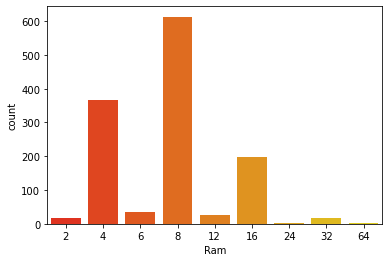

In [41]:
sns.countplot(df['Ram'], palette='autumn');

> Most common laptops have 4, 6 and 16 GB as the RAM 

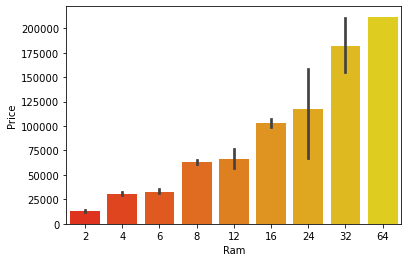

In [42]:
# comparison of ram with price 

sns.barplot(df['Ram'], df['Price'], palette='autumn');

**We could see a increasing trend here, as Ram increases the average price of the laptop also increases**

**About the memory column**

we have different type of categories like SSD, HDD, combination of SSD & HDD etc.. 

Need to pre process the text and drill down to few categories.

In [43]:
df['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          215
500GB HDD                        123
512GB SSD                        114
128GB SSD +  1TB HDD              94
128GB SSD                         74
256GB SSD +  1TB HDD              73
32GB Flash Storage                36
2TB HDD                           16
512GB SSD +  1TB HDD              14
1TB SSD                           14
64GB Flash Storage                13
256GB SSD +  2TB HDD              10
256GB Flash Storage                8
16GB Flash Storage                 7
1.0TB Hybrid                       7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [44]:
## most common observed categories are SSD, HDD, flash and hybrid 

# to remove decimal place ex: 1.0TB -> 1TB
df['Memory'] = df['Memory'].str.replace('\.0', '', regex=True)

# replace GB with space
df['Memory'] = df['Memory'].str.replace('GB', '')

#replace the TB word with 000 (maintaining GB as common measure)
df['Memory'] = df['Memory'].str.replace('TB', '000')

# split the word across "+" character
newdf = df['Memory'].str.split("+", n=1, expand=True)
newdf.head()


0     1
0            128 SSD  None
1  128 Flash Storage  None
2            256 SSD  None
3            512 SSD  None
4            256 SSD  None

In [45]:
df['Memory'].sample(20)

971                 256 SSD
292                1000 HDD
537                 256 SSD
1269                500 HDD
1151                500 HDD
857                 256 SSD
187                 256 SSD
287                 256 SSD
773                1000 HDD
569                 500 HDD
786     128 SSD +  1000 HDD
223                1000 HDD
1165    128 SSD +  1000 HDD
1077    256 SSD +  1000 HDD
599                 256 SSD
1056                500 HDD
817        16 Flash Storage
1236                256 SSD
799                 256 SSD
1014                500 HDD
Name: Memory, dtype: object

> Maintaining all above numeric values in GB only 

In [46]:
# now splitting the first part and stripping off the spaces 

df['first'] = newdf[0]
df['first'] = df['first'].str.strip()
df.sample(10)

Company   TypeName  Ram               Memory                      Gpu  \
686         HP   Notebook    4              500 HDD           AMD Radeon 520   
533   Mediacom   Notebook    4               32 SSD    Intel HD Graphics 500   
667         HP   Notebook    8             1000 HDD           AMD Radeon 530   
1246      Dell   Notebook    4              500 HDD    Intel HD Graphics 620   
20        Asus    Netbook    2     32 Flash Storage    Intel HD Graphics 400   
363         HP   Notebook    8             1000 HDD    Intel HD Graphics 620   
937        MSI     Gaming    8  128 SSD +  1000 HDD  Nvidia GeForce GTX 1050   
347       Dell  Ultrabook   16   512 SSD +  256 SSD   Intel UHD Graphics 620   
1106       MSI     Gaming    8  128 SSD +  1000 HDD  Nvidia GeForce GTX 960M   
356     Lenovo   Notebook    4             1000 HDD    Intel HD Graphics 500   

           OpSys  Weight       Price  TouchScreen  IPS         PPI  \
686   Windows 10    1.86  32639.8608            0    0  100.454666   
533   Windows 10    1.20  19660.3200            0    1  165.632111   
667   Windows 10    2.10  39693.6000            0    0  141.212006   
1246  Windows 10    1.60  46620.0000            0    0  111.935204   
20    Windows 10    0.98  10224.4320            0    0  135.094208   
363   Windows 10    1.86  34045.9200            0    0  141.212006   
937   Windows 10    2.20  63882.7200            0    0  141.212006   
347   Windows 10    1.88  85672.1088            0    0  141.212006   
1106  Windows 10    2.90  80516.2032            0    0  127.335678   
356        No OS    2.20  17155.6272            0    0  100.454666   

                   CPU_name             first  
686           Intel Core i5           500 HDD  
533   Other Intel Processor            32 SSD  
667           Intel Core i7          1000 HDD  
1246          Intel Core i5           500 HDD  
20    Other Intel Processor  32 Flash Storage  
363           Intel Core i5          1000 HDD  
937           Intel Core i7           128 SSD  
347           Intel Core i7           512 SSD  
1106          Intel Core i7           128 SSD  
356   Other Intel Processor          1000 HDD

In [47]:
# performing one hot encoding on first column which gives four new variables as below

def one_hot_encoding(val):
    df['Memory'+val] = df['first'].apply(lambda x: 1 if val in x else 0)


list_to_apply = ['SSD', 'HDD', 'Hybrid', 'FlashStorage']
for val in list_to_apply:
    one_hot_encoding(val)
    
df.sample(10)

Company            TypeName  Ram                Memory  \
659        Dell              Gaming   32   512 SSD +  1000 HDD   
364      Lenovo            Notebook    8               256 SSD   
189        Dell            Notebook    8   128 SSD +  1000 HDD   
327        Asus           Ultrabook    8               256 SSD   
181        Dell           Ultrabook    8               256 SSD   
546      Lenovo            Notebook    4               500 HDD   
70    Microsoft           Ultrabook    4               128 SSD   
639        Dell            Notebook   16              1000 SSD   
1270     Lenovo  2 in 1 Convertible    4               128 SSD   
780        Dell              Gaming   32  1000 SSD +  1000 HDD   

                           Gpu         OpSys  Weight        Price  \
659    Nvidia GeForce GTX 1070    Windows 10   4.420  167691.8736   
364      Nvidia GeForce 920MX          No OS   2.200   26586.7200   
189             AMD Radeon 530    Windows 10   2.800   57808.8000   
327       Nvidia GeForce 940MX    Windows 10   1.700   55938.6720   
181     Intel UHD Graphics 620    Windows 10   1.230   74538.7200   
546      Intel HD Graphics 620    Windows 10   1.870   41824.8000   
70       Intel HD Graphics 620  Windows 10 S   1.252   58021.9200   
639    Nvidia GeForce GTX 1050    Windows 10   2.060  127818.7200   
1270     Intel HD Graphics 520    Windows 10   1.800   33992.6400   
780   Nvidia GeForce GTX 1070M    Windows 10   4.420  191211.2640   

      TouchScreen  IPS         PPI       CPU_name     first  MemorySSD  \
659             0    1  254.671356  Intel Core i7   512 SSD          1   
364             0    0  100.454666  Intel Core i3   256 SSD          1   
189             0    0  127.335678  Intel Core i7   128 SSD          1   
327             0    0  141.212006  Intel Core i7   256 SSD          1   
181             0    0  165.632111  Intel Core i5   256 SSD          1   
546             0    0  157.350510  Intel Core i5   500 HDD          0   
70              1    0  200.842560  Intel Core i5   128 SSD          1   
639             1    0  282.424011  Intel Core i7  1000 SSD          1   
1270            1    1  157.350510  Intel Core i7   128 SSD          1   
780             0    1  127.335678  Intel Core i7  1000 SSD          1   

      MemoryHDD  MemoryHybrid  MemoryFlashStorage  
659           0             0                   0  
364           0             0                   0  
189           0             0                   0  
327           0             0                   0  
181           0             0                   0  
546           1             0                   0  
70            0             0                   0  
639           0             0                   0  
1270          0             0                   0  
780           0             0                   0

In [48]:
# removing all characters in the first column as we have created separate columns for memory categories

df['first'] = df['first'].str.replace('\D','')
df['first']

0        128
1        128
2        256
3        512
4        256
5        500
6        256
7        256
8        512
9        256
10       500
11       500
12       256
13       256
14       256
15       256
16       256
17       512
18      1000
19       128
20        32
21       128
22       500
23       256
24       256
25      1000
26       128
27       256
28       256
29      1000
30        64
31        32
32       500
33       512
34       256
35        64
36      1000
37       128
38      1000
39       256
40      1000
41       256
42      1000
43       256
44      1000
45       256
46       128
47       256
48       256
49      1000
50        64
51       256
52       256
53       512
54      1000
55       256
56       128
57       256
58       256
59       256
60       256
61       256
62       256
63       256
64       256
65       512
66       500
67        32
68      1000
69      1000
70       128
71       256
72       256
73       128
74      1000
75      1000
76      2000

In [49]:
# to get the second combination of memory (which is SSD plus HDD)

df['second'] = newdf[1]
df.sample(10)

Company            TypeName  Ram               Memory  \
706     Acer  2 in 1 Convertible    8              256 SSD   
302   Lenovo            Notebook    6             1000 HDD   
20      Asus             Netbook    2     32 Flash Storage   
126       HP            Notebook    8             1000 HDD   
1062    Dell            Notebook    4             1000 HDD   
308   Lenovo            Notebook    8  128 SSD +  1000 HDD   
1055      HP            Notebook    4              500 HDD   
467     Dell            Notebook    8             2000 HDD   
78      Acer            Notebook    4             1000 HDD   
31      Asus            Notebook    2     32 Flash Storage   

                          Gpu       OpSys  Weight      Price  TouchScreen  \
706    Intel UHD Graphics 620  Windows 10    1.60  53226.720            1   
302   Nvidia GeForce GTX 940M  Windows 10    2.80  34578.720            0   
20      Intel HD Graphics 400  Windows 10    0.98  10224.432            0   
126    Intel UHD Graphics 620  Windows 10    1.63  43263.360            0   
1062        Intel HD Graphics  Windows 10    2.25  29783.520            0   
308      Nvidia GeForce 940MX  Windows 10    2.30  43636.320            0   
1055    Intel HD Graphics 520  Windows 10    2.31  37570.392            0   
467            AMD Radeon 530  Windows 10    2.02  40439.520            0   
78       Nvidia GeForce MX130  Windows 10    2.20  28238.400            0   
31              AMD Radeon R2  Windows 10    1.65  10602.720            0   

      IPS         PPI               CPU_name first  MemorySSD  MemoryHDD  \
706     1  165.632111          Intel Core i5   256          1          0   
302     0  106.113060          Intel Core i5  1000          0          1   
20      0  135.094208  Other Intel Processor    32          0          0   
126     0  157.350510          Intel Core i5  1000          0          1   
1062    0  141.212006          Intel Core i5  1000          0          1   
308     0  141.212006          Intel Core i5   128          1          0   
1055    0  100.454666          Intel Core i3   500          0          1   
467     0  141.212006          Intel Core i5  2000          0          1   
78      0  141.212006          Intel Core i3  1000          0          1   
31      0  111.935204          AMD Processor    32          0          0   

      MemoryHybrid  MemoryFlashStorage      second  
706              0                   0        None  
302              0                   0        None  
20               0                   0        None  
126              0                   0        None  
1062             0                   0        None  
308              0                   0    1000 HDD  
1055             0                   0        None  
467              0                   0        None  
78               0                   0        None  
31               0                   0        None

In [50]:
# performing same one hot encoding on second column which gives four new variables as below

def one_hot_encoding(val):
    df['Memory_2'+val] = df['second'].apply(lambda x: 1 if val in x else 0)


list_to_apply = ['SSD', 'HDD', 'Hybrid', 'FlashStorage']
df['second'] = df['second'].fillna("0") # because there are many None records
for val in list_to_apply:
    one_hot_encoding(val)
    
df['second'] = df['second'].str.replace(r'\D','')

df.sample(10)

Company   TypeName  Ram               Memory  \
434    Lenovo   Notebook   16              512 SSD   
768   Samsung  Ultrabook    8              256 SSD   
822    Lenovo  Ultrabook    8              512 SSD   
246        HP   Notebook    8             1000 HDD   
249     Apple  Ultrabook    8              512 SSD   
1170       HP   Notebook    8              256 SSD   
362    Lenovo   Notebook    6  128 SSD +  1000 HDD   
224      Dell     Gaming   16  256 SSD +  1000 HDD   
530      Dell     Gaming   16  128 SSD +  1000 HDD   
40       Asus   Notebook    4             1000 HDD   

                               Gpu       OpSys  Weight        Price  \
434           Nvidia Quadro M2200M  Windows 10    2.50  130482.7200   
768          Intel HD Graphics 620  Windows 10    1.31   85194.7200   
822          Intel HD Graphics 620  Windows 10    1.13  133146.7200   
246          Intel HD Graphics 620  Windows 10    2.04   29783.5200   
249   Intel Iris Plus Graphics 650       macOS    1.37  108691.2000   
1170         Intel HD Graphics 520  Windows 10    1.96   36177.1200   
362       Nvidia GeForce GTX 940MX  Windows 10    2.80   38308.3200   
224        Nvidia GeForce GTX 1060  Windows 10    4.42  130873.7952   
530        Nvidia GeForce GTX 1070  Windows 10    4.42  160520.3856   
40           Intel HD Graphics 620       Linux    2.00   20725.9200   

      TouchScreen  IPS         PPI       CPU_name first  MemorySSD  MemoryHDD  \
434             0    0  141.212006  Intel Core i7   512          1          0   
768             1    0  165.632111  Intel Core i7   256          1          0   
822             0    1  157.350510  Intel Core i7   512          1          0   
246             1    0  100.454666  Intel Core i5  1000          0          1   
249             0    1  226.983002  Intel Core i5   512          1          0   
1170            0    0  141.212006  Intel Core i7   256          1          0   
362             0    0  106.113060  Intel Core i5   128          1          0   
224             0    1  127.335678  Intel Core i7   256          1          0   
530             0    1  127.335678  Intel Core i7   128          1          0   
40              0    0  141.212006  Intel Core i3  1000          0          1   

      MemoryHybrid  MemoryFlashStorage second  Memory_2SSD  Memory_2HDD  \
434              0                   0      0            0            0   
768              0                   0      0            0            0   
822              0                   0      0            0            0   
246              0                   0      0            0            0   
249              0                   0      0            0            0   
1170             0                   0      0            0            0   
362              0                   0   1000            0            1   
224              0                   0   1000            0            1   
530              0                   0   1000            0            1   
40               0                   0      0            0            0   

      Memory_2Hybrid  Memory_2FlashStorage  
434                0                     0  
768                0                     0  
822                0                     0  
246                0                     0  
249                0                     0  
1170               0                     0  
362                0                     0  
224                0                     0  
530                0                     0  
40                 0                     0

In [51]:
df.sample(15)

Company            TypeName  Ram               Memory  \
1239   Lenovo            Notebook   16              512 SSD   
413      Acer  2 in 1 Convertible    8              256 SSD   
1137     Dell            Notebook    8             1000 HDD   
336      Dell           Ultrabook    8  128 SSD +  1000 HDD   
1201   Lenovo            Notebook    8              500 HDD   
943   Toshiba            Notebook    8              256 SSD   
164      Acer            Notebook    4             1000 HDD   
1167   Lenovo            Notebook    4             1000 HDD   
261    Lenovo            Notebook    4              256 SSD   
945    Lenovo              Gaming   16  512 SSD +  1000 HDD   
782   Toshiba           Ultrabook   16              512 SSD   
244    Lenovo  2 in 1 Convertible    8              256 SSD   
1141      MSI              Gaming    8  128 SSD +  1000 HDD   
1101     Dell           Ultrabook    4              128 SSD   
918      Dell              Gaming   16  128 SSD +  1000 HDD   

                             Gpu       OpSys  Weight       Price  TouchScreen  \
1239       Intel HD Graphics 620  Windows 10    1.40  79866.7200            0   
413        Intel HD Graphics 520  Windows 10    1.60  42038.4528            1   
1137          AMD Radeon R7 M445  Windows 10    2.50  41771.5200            0   
336         Nvidia GeForce 940MX  Windows 10    1.90  55890.7200            0   
1201        Nvidia GeForce 920MX       No OS    2.20  33513.1200            0   
943        Intel HD Graphics 520  Windows 10    2.20  59620.3200            0   
164        Intel HD Graphics 500  Windows 10    2.10  18541.4400            0   
1167       Nvidia GeForce 920MX   Windows 10    2.20  24935.0400            0   
261        Intel HD Graphics 520       No OS    2.20  23656.3200            0   
945           AMD Radeon R9 M385  Windows 10    2.50  53226.7200            0   
782          Nvidia GeForce 930M  Windows 10    1.47  93985.9200            0   
244        Intel HD Graphics 620  Windows 10    1.38  57489.1200            1   
1141     Nvidia GeForce GTX 1050  Windows 10    2.40  60888.3840            0   
1101       Intel HD Graphics 520   Windows 7    1.50  62176.1616            0   
918   Nvidia GeForce GTX 1050 Ti  Windows 10    2.60  71874.7200            0   

      IPS         PPI               CPU_name first  MemorySSD  MemoryHDD  \
1239    1  165.632111          Intel Core i7   512          1          0   
413     1  165.632111          Intel Core i7   256          1          0   
1137    0  100.454666          Intel Core i5  1000          0          1   
336     1  141.212006          Intel Core i5   128          1          0   
1201    0  100.454666          Intel Core i7   500          0          1   
943     0  100.454666          Intel Core i5   256          1          0   
164     0  100.454666  Other Intel Processor  1000          0          1   
1167    0  141.212006          Intel Core i3  1000          0          1   
261     0  141.212006          Intel Core i3   256          1          0   
945     1  141.212006          AMD Processor   512          1          0   
782     1  157.350510          Intel Core i7   512          1          0   
244     1  158.482529          Intel Core i7   256          1          0   
1141    0  141.212006          Intel Core i7   128          1          0   
1101    0  125.367432          Intel Core i3   128          1          0   
918     0  141.212006          Intel Core i7   128          1          0   

      MemoryHybrid  MemoryFlashStorage second  Memory_2SSD  Memory_2HDD  \
1239             0                   0      0            0            0   
413              0                   0      0            0            0   
1137             0                   0      0            0            0   
336              0                   0   1000            0            1   
1201             0                   0      0            0            0   
943              0               

In [52]:
df['first'] = df['first'].astype('int32')
df['second'] = df['second'].astype('int32')

In [53]:
df['second'].value_counts()

0       1066
1000     187
2000      15
256        3
500        2
512        1
Name: second, dtype: int64

> Create a four new variables which will have all above derived data in a meaningful manner.

In [54]:
df['HDD'] = df['first'] * df['MemoryHDD'] + df['second'] * df['Memory_2HDD']
df['SSD'] = df['first'] * df['MemorySSD'] + df['second'] * df['Memory_2SSD']
df['Hybrid'] = df['first'] * df['MemoryHybrid'] + df['second'] * df['Memory_2Hybrid']
df['FlashStorage'] = df['first'] * df['MemoryFlashStorage'] + df['second'] * df['Memory_2FlashStorage']


# dropping unnecessary columns

df.drop(['first', 'second', 'MemorySSD','MemoryHDD','MemoryHybrid', 'MemoryFlashStorage',
        'Memory_2SSD','Memory_2HDD','Memory_2Hybrid', 'Memory_2FlashStorage'], axis=1,inplace=True)

In [55]:
df.sample(10)

Company            TypeName  Ram               Memory  \
1017  Lenovo            Notebook   16              512 SSD   
562       HP           Ultrabook   16              512 SSD   
272     Dell            Notebook    8              256 SSD   
243     Dell              Gaming    8              256 SSD   
1099    Asus              Gaming   16  128 SSD +  1000 HDD   
555     Asus            Notebook    4              500 HDD   
736       HP         Workstation   16              256 SSD   
737     Dell  2 in 1 Convertible    8             1000 HDD   
279   Lenovo            Notebook    8             2000 HDD   
838   Lenovo            Notebook    4     16 Flash Storage   

                          Gpu       OpSys  Weight        Price  TouchScreen  \
1017      Nvidia Quadro 3000M   Windows 7    2.40  158135.0400            0   
562     Intel HD Graphics 515  Windows 10    1.16  104695.2000            1   
272            AMD Radeon 520       Linux    2.14   39164.5296            0   
243   Nvidia GeForce GTX 1050  Windows 10    2.56   46833.1200            0   
1099  Nvidia GeForce GTX 980M  Windows 10    4.30  122490.7200            0   
555     Intel HD Graphics 500       Linux    2.00   11934.7200            0   
736       Nvidia Quadro M2200  Windows 10    2.60  128884.3200            0   
737    Intel UHD Graphics 620  Windows 10    1.55   35111.5200            1   
279      Nvidia GeForce MX150       No OS    2.80   45234.7200            0   
838     Intel HD Graphics 400   Chrome OS    1.50   17316.0000            0   

      IPS         PPI               CPU_name   HDD  SSD  Hybrid  FlashStorage  
1017    1  254.671356          Intel Core i7     0  512       0             0  
562     1  276.053528  Other Intel Processor     0  512       0             0  
272     0  141.212006          Intel Core i7     0  256       0             0  
243     0  141.212006          Intel Core i5     0  256       0             0  
1099    1  127.335678          Intel Core i7  1000  128       0             0  
555     0  100.454666  Other Intel Processor   500    0       0             0  
736     0  141.212006          Intel Core i7     0  256       0             0  
737     0  165.632111          Intel Core i5  1000    0       0             0  
279     0  127.335678          Intel Core i7  2000    0       0             0  
838     0  111.935204  Other Intel Processor     0    0       0             0

In [56]:
# removing the base column which is Memory 

df.drop(['Memory'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram                           Gpu  OpSys  Weight  \
0   Apple  Ultrabook    8  Intel Iris Plus Graphics 640  macOS    1.37   
1   Apple  Ultrabook    8        Intel HD Graphics 6000  macOS    1.34   
2      HP   Notebook    8         Intel HD Graphics 620  No OS    1.86   
3   Apple  Ultrabook   16            AMD Radeon Pro 455  macOS    1.83   
4   Apple  Ultrabook    8  Intel Iris Plus Graphics 650  macOS    1.37   

         Price  TouchScreen  IPS         PPI       CPU_name  HDD  SSD  Hybrid  \
0   71378.6832            0    1  226.983002  Intel Core i5    0  128       0   
1   47895.5232            0    0  127.677940  Intel Core i5    0    0       0   
2   30636.0000            0    0  141.212006  Intel Core i5    0  256       0   
3  135195.3360            0    1  220.534622  Intel Core i7    0  512       0   
4   96095.8080            0    1  226.983002  Intel Core i5    0  256       0   

   FlashStorage  
0             0  
1             0  
2             0  
3             0  
4             0

In [57]:
# let's find relation between our new features and Price

df.corr()['Price']

Ram             0.740106
Weight          0.212192
Price           1.000000
TouchScreen     0.188631
IPS             0.250358
PPI             0.469539
HDD            -0.098011
SSD             0.669957
Hybrid          0.022533
FlashStorage         NaN
Name: Price, dtype: float64

**Based on correlation values above, `hybrid and FlashStorage` doesn't have good relation with target, we could drop these variables. SSD has positive correlation with Price and HDD has negative correlation which indicates price of laptop decreases when increase in HDD which is quite opposite to SSD**

In [58]:
df.drop(['Hybrid', 'FlashStorage'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram                           Gpu  OpSys  Weight  \
0   Apple  Ultrabook    8  Intel Iris Plus Graphics 640  macOS    1.37   
1   Apple  Ultrabook    8        Intel HD Graphics 6000  macOS    1.34   
2      HP   Notebook    8         Intel HD Graphics 620  No OS    1.86   
3   Apple  Ultrabook   16            AMD Radeon Pro 455  macOS    1.83   
4   Apple  Ultrabook    8  Intel Iris Plus Graphics 650  macOS    1.37   

         Price  TouchScreen  IPS         PPI       CPU_name  HDD  SSD  
0   71378.6832            0    1  226.983002  Intel Core i5    0  128  
1   47895.5232            0    0  127.677940  Intel Core i5    0    0  
2   30636.0000            0    0  141.212006  Intel Core i5    0  256  
3  135195.3360            0    1  220.534622  Intel Core i7    0  512  
4   96095.8080            0    1  226.983002  Intel Core i5    0  256

#### Analysis on GPU 

In [59]:
df['Gpu'].value_counts()

Intel HD Graphics 620             279
Intel HD Graphics 520             181
Intel UHD Graphics 620             68
Nvidia GeForce GTX 1050            66
Nvidia GeForce GTX 1060            48
Nvidia GeForce 940MX               43
AMD Radeon 530                     41
Intel HD Graphics 500              39
Intel HD Graphics 400              33
Nvidia GeForce GTX 1070            30
Nvidia GeForce GTX 1050 Ti         28
Intel HD Graphics                  22
Nvidia GeForce 930MX               20
AMD Radeon R5 M430                 20
AMD Radeon 520                     17
Nvidia GeForce MX150               15
AMD Radeon R7 M445                 14
Intel HD Graphics 615              14
Nvidia GeForce 920MX               13
Intel HD Graphics 515              13
Nvidia GeForce GTX 960M            12
Intel HD Graphics 505              12
AMD Radeon R5                      11
Nvidia GeForce GTX 980M            10
Nvidia Quadro M1200                 9
Intel HD Graphics 405               9
Intel Iris P

**In GPU column, as there are many models available in different brands, we will consider only brand names like Intel, Nvidia etc..**

In [60]:
# extracting only gpu brands

df['Gpu_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df['Gpu_brand'].value_counts()

Intel     703
Nvidia    396
AMD       174
ARM         1
Name: Gpu_brand, dtype: int64

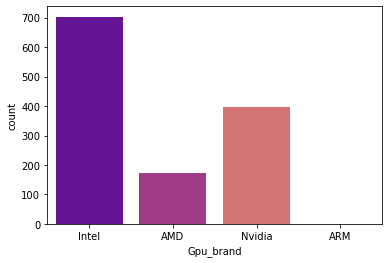

In [61]:
sns.countplot(df['Gpu_brand'], palette='plasma');

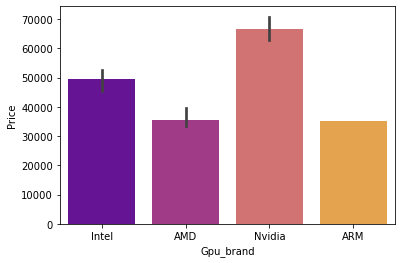

In [62]:
sns.barplot(df['Gpu_brand'], df['Price'], palette='plasma', estimator=np.median);

> We observe that laptops with Nvidia GPU's are expensive than other laptop which is common in general

In [63]:
# dropping gpu column 

df.drop(['Gpu'], axis=1, inplace=True)
df.head()

Company   TypeName  Ram  OpSys  Weight        Price  TouchScreen  IPS  \
0   Apple  Ultrabook    8  macOS    1.37   71378.6832            0    1   
1   Apple  Ultrabook    8  macOS    1.34   47895.5232            0    0   
2      HP   Notebook    8  No OS    1.86   30636.0000            0    0   
3   Apple  Ultrabook   16  macOS    1.83  135195.3360            0    1   
4   Apple  Ultrabook    8  macOS    1.37   96095.8080            0    1   

          PPI       CPU_name  HDD  SSD Gpu_brand  
0  226.983002  Intel Core i5    0  128     Intel  
1  127.677940  Intel Core i5    0    0     Intel  
2  141.212006  Intel Core i5    0  256     Intel  
3  220.534622  Intel Core i7    0  512       AMD  
4  226.983002  Intel Core i5    0  256     Intel

##### Operating system analysis 

In [64]:
df['OpSys'].value_counts()

Windows 10      1047
No OS             66
Linux             58
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: OpSys, dtype: int64

**Note:**

No OS could be a option where missing value or OS is not mentioned in the data 

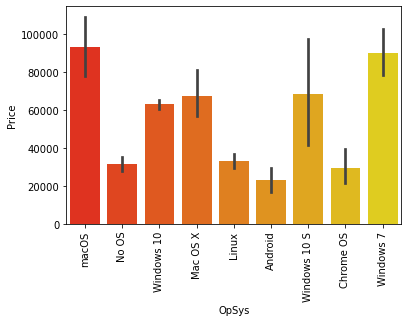

In [65]:
sns.barplot(df['OpSys'], df['Price'], palette='autumn')
plt.xticks(rotation='vertical')
plt.show()

> Laptops which have MacOS are expensive followed by Windows 7

In [66]:
def preprocess_ostypes(val):
    # clubbing all above categories into 3 common types windows, MacOs and other
    
    if val in ['Windows 7', 'Windows 10 s', 'Windows 10']:
        return "Windows"
    else:
        if val in ['macOS', 'Max OS X']:
            return "Mac"
        else:
            return "Other"
    
df['OpSys'] = df['OpSys'].apply(preprocess_ostypes)
df.sample(10)

Company   TypeName  Ram    OpSys  Weight       Price  TouchScreen  IPS  \
895   Toshiba   Notebook    8  Windows    1.05  78588.0000            0    0   
401      Asus     Gaming   16  Windows    2.90  81465.1200            0    0   
637    Lenovo   Notebook    2  Windows    1.42  13266.7200            0    0   
11         HP   Notebook    4    Other    1.86  18381.0672            0    0   
394      Dell   Notebook    8    Other    2.33  41498.1936            0    0   
1057     Acer   Notebook    8  Windows    2.40  23922.7200            0    0   
1272   Lenovo   Notebook    2  Windows    1.50  12201.1200            0    0   
203    Lenovo     Gaming   16  Windows    3.20  93186.7200            0    1   
988      Dell   Notebook    8  Windows    2.36  39906.7200            0    0   
344      Dell  Ultrabook    8  Windows    1.20  84129.1200            0    0   

             PPI               CPU_name   HDD  SSD Gpu_brand  
895   165.632111          Intel Core i5     0  256     Intel  
401   127.335678          Intel Core i7  1000  256    Nvidia  
637   111.935204  Other Intel Processor     0    0     Intel  
11    141.212006          Intel Core i3   500    0     Intel  
394   141.212006          Intel Core i7     0  256       AMD  
1057  100.454666          AMD Processor  1000    0       AMD  
1272  111.935204  Other Intel Processor     0    0     Intel  
203   141.212006          Intel Core i7  1000  512    Nvidia  
988   100.454666          Intel Core i7  1000    0       AMD  
344   165.632111          Intel Core i7     0  256     Intel

In [67]:
df['OpSys'].value_counts()

Windows    1092
Other       169
Mac          13
Name: OpSys, dtype: int64

#### Weight feature analysis

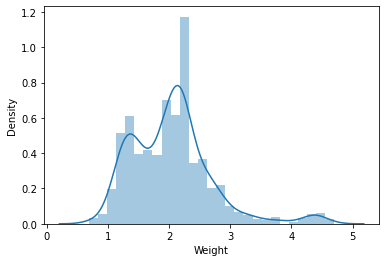

In [68]:
sns.distplot(df['Weight']);

* Laptop's weights is in range between 0.7 Kg and 5 Kgs
* Most of the laptops are in the range of 1.2 Kg and 2.7 kgs

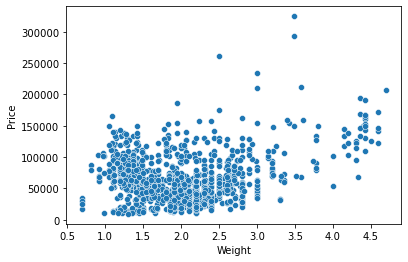

In [69]:
sns.scatterplot(df['Weight'], df['Price']);

#### Price analysis 

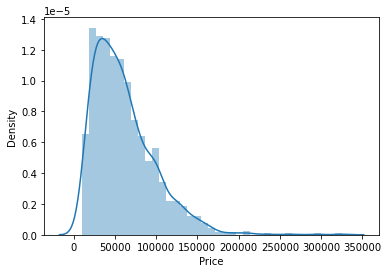

In [70]:
sns.distplot(df['Price']);

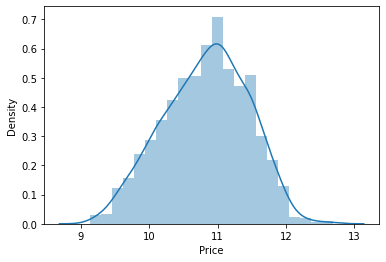

In [71]:
sns.distplot(np.log(df['Price']));

We applied logarithmic transformation to the Price feature, so it becomes gaussian distribution. It is well known that 
data which has normal distribution has good prediction performance on some models 

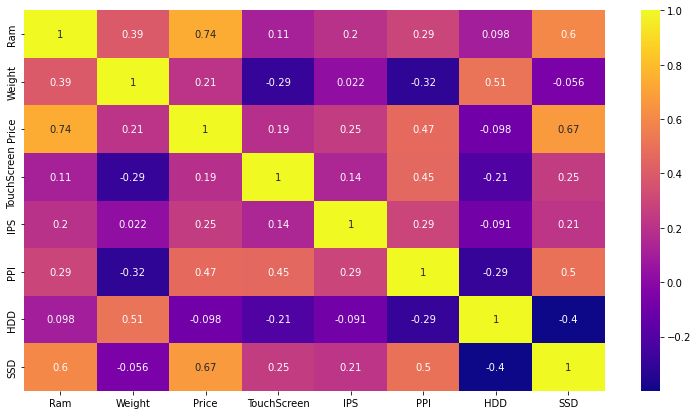

In [72]:
# let's see the correlation matrix now 

plt.figure(figsize=(13,7))
sns.heatmap(df.corr(), annot=True, cmap='plasma');

From above matrix 

* Ram, SSD, PPI are most likely best predictors 
* IPS, Touch Screen and Weight are average predictors 

## Model Building 

Pre-processing of the data is completed except for encoding the categorical variables. 

Let's build a model and find a best one.

In [73]:
"""
Separating train and test set, also applying logarithm on target variable Price, to get back same 
value, it is possible to get using exp
"""

train = df.drop(['Price'], axis=1)
test = np.log(df['Price'])

In [74]:
train.head()

Company   TypeName  Ram  OpSys  Weight  TouchScreen  IPS         PPI  \
0   Apple  Ultrabook    8    Mac    1.37            0    1  226.983002   
1   Apple  Ultrabook    8    Mac    1.34            0    0  127.677940   
2      HP   Notebook    8  Other    1.86            0    0  141.212006   
3   Apple  Ultrabook   16    Mac    1.83            0    1  220.534622   
4   Apple  Ultrabook    8    Mac    1.37            0    1  226.983002   

        CPU_name  HDD  SSD Gpu_brand  
0  Intel Core i5    0  128     Intel  
1  Intel Core i5    0    0     Intel  
2  Intel Core i5    0  256     Intel  
3  Intel Core i7    0  512       AMD  
4  Intel Core i5    0  256     Intel

In [75]:
train.to_csv('trainned_data.csv', index=False)

In [76]:
test[:10]

0    11.175755
1    10.776777
2    10.329931
3    11.814476
4    11.473101
5     9.967026
6    11.644108
7    11.030615
8    11.285443
9    10.621952
Name: Price, dtype: float64

In [77]:
# splitting train and test set 

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.15, 
                                                   random_state=2)

X_train.shape, X_test.shape

((1082, 12), (192, 12))

**For Column Transformer, we will be applying transformations on categorical data, also it requires an input of column
names or their index numbers. Here we will give index numbers as input.**

In [78]:
# to get index num of categorical columns

mapper = {i: val for i, val in enumerate(X_train.columns)}
mapper

{0: 'Company',
 1: 'TypeName',
 2: 'Ram',
 3: 'OpSys',
 4: 'Weight',
 5: 'TouchScreen',
 6: 'IPS',
 7: 'PPI',
 8: 'CPU_name',
 9: 'HDD',
 10: 'SSD',
 11: 'Gpu_brand'}

#### Linear Regression 

In [79]:
# applying one hot encoding to categorical columns and building a model 

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE score: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score:  0.804875740203544
MAE score:  0.2069799251430616
RMSE score:  0.2661333586387836


In [80]:
np.exp(0.207)

1.2299825717807527

**Conclusions:**

* R2 score indicates 82% of variability in Price is explained by all of the predictors.
* MAE score indicates on an average there is 0.20 error difference but it is in log scale, so after taking exp value,
  we confirm that only 1.22 Rs increase or decrease with respect to original price is observed

In [81]:
print(list(np.exp(y_pred[:5])))
print(list(np.exp(y_test[:5])))

[45344.02188250147, 45254.289991084595, 20241.54776709191, 144415.3521460791, 23526.69040838643]
[35964.000000000015, 48618.0, 18061.919999999995, 144495.36, 21258.719999999987]


#### Ridge regression 

In [82]:
# applying Ridge regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = Ridge(alpha=10)

ridge_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

ridge_pipe.fit(X_train, y_train)

y_pred = ridge_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE score: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score:  0.8051890060005471
MAE score:  0.20890382390972076
RMSE score:  0.2659196385000328


#### Lasso regression 

In [83]:
# applying lasso regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = Lasso(alpha=0.001)

lasso_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

lasso_pipe.fit(X_train, y_train)

y_pred = lasso_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE score: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score:  0.7997649644258699
MAE score:  0.20986664139170239
RMSE score:  0.269596168181722


> Among all three linear models, based on R2 score and MAE score, Linear regression is the best model without any hyper parameter tuning.

#### Decision Tree 

In [84]:
# applying decision tree regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = DecisionTreeRegressor(max_depth=8)

tree_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

tree_pipe.fit(X_train, y_train)

y_pred = tree_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE score: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score:  0.8085086239550172
MAE score:  0.20667807283778447
RMSE score:  0.2636442418718743


#### Random Forest 

In [85]:
# applying Random forest regression to the data

step1 = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse=False, drop='first'), [0,1,3,8,11])], 
                         remainder='passthrough')

step2 = RandomForestRegressor(n_estimators = 100,
                             random_state = 3,
                             max_samples = 0.5,
                             max_features = 0.75,
                             max_depth = 15)

rf_pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)

print("R2 score: ", metrics.r2_score(y_test, y_pred))
print("MAE score: ", metrics.mean_absolute_error(y_test, y_pred))
print("RMSE score: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score:  0.8806641053328403
MAE score:  0.16269163823747926
RMSE score:  0.2081273848357357


**The score has been improved a lot using random forest model which could be a best model so far** 

In [86]:
# we will store the model as pickel file 

import pickle

pickle.dump(df, open('processed_df.pkl', 'wb'))
pickle.dump(rf_pipe, open('rf_pipe.pkl', 'wb'))

### Hyper parameter tuning for random forest 

Since Random forest model have good perfomance metrics on the data, we will try tuning the hyper parameters to check
whether we could further improve the model 

In [87]:
# doing from the first for tuning 

index_list = [0, 1, 3, 8, 11]
transform_list = []

for key, value in mapper.items():
    if key in index_list:
        transform_list.append(value)
        
print(transform_list)

['Company', 'TypeName', 'OpSys', 'CPU_name', 'Gpu_brand']


In [88]:
X = pd.get_dummies(train, columns=transform_list, drop_first=True)
X.head()

Ram  Weight  TouchScreen  IPS         PPI  HDD  SSD  Company_Apple  \
0    8    1.37            0    1  226.983002    0  128              1   
1    8    1.34            0    0  127.677940    0    0              1   
2    8    1.86            0    0  141.212006    0  256              0   
3   16    1.83            0    1  220.534622    0  512              1   
4    8    1.37            0    1  226.983002    0  256              1   

   Company_Asus  Company_Chuwi  Company_Dell  Company_Fujitsu  Company_Google  \
0             0              0             0                0               0   
1             0              0             0                0               0   
2             0              0             0                0               0   
3             0              0             0                0               0   
4             0              0             0                0               0   

   Company_HP  Company_Huawei  Company_LG  Company_Lenovo  Company_MSI  \
0           0               0           0               0            0   
1           0               0           0               0            0   
2           1               0           0               0            0   
3           0               0           0               0            0   
4           0               0           0               0            0   

   Company_Mediacom  Company_Microsoft  Company_Razer  Company_Samsung  \
0                 0                  0              0                0   
1                 0                  0              0                0   
2                 0                  0              0                0   
3                 0                  0              0                0   
4                 0                  0              0                0   

   Company_Toshiba  Company_Vero  Company_Xiaomi  TypeName_Gaming  \
0                0             0               0                0   
1                0             0               0                0   
2                0             0               0                0   
3                0             0               0                0   
4                0             0               0                0   

   TypeName_Netbook  TypeName_Notebook  TypeName_Ultrabook  \
0                 0                  0                   1   
1                 0                  0                   1   
2                 0                  1                   0   
3                 0                  0                   1   
4                 0                  0                   1   

   TypeName_Workstation  OpSys_Other  OpSys_Windows  CPU_name_Intel Core i3  \
0                     0            0              0                       0   
1                     0            0              0                       0   
2                     0            1              0                       0   
3                     0            0              0                       0   
4                     0            0              0                       0   

   CPU_name_Intel Core i5  CPU_name_Intel Core i7  \
0                       1                       0   
1                       1                       0   
2                       1                       0   
3                       0                       1   
4                       1                       0   

   CPU_name_Other Intel Processor  Gpu_brand_ARM  Gpu_brand_Intel  \
0                               0              0                1   
1                               0              0                1   
2                               0              0                1   
3                               0              0                0   
4                               0              0                1   

   Gpu_brand_Nvidia  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, test, test_size=0.15, random_state=2)

X_train.shape, X_test.shape

((1082, 39), (192, 39))

In [90]:
reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)
plt.figure(figsize=(16,9))
# tree.plot_tree(reg, filled=True, feature_names=X.columns)
# plt.show()

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

> Here we haven't given any parameters, so it will build a tree randomly which is not a optimized or a perfect one

In [91]:
# tuning one hyper parameter which is pruning 

path = reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [92]:
alpha_list = []

for alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    reg.fit(X_train, y_train)
    alpha_list.append(reg)

In [93]:
alpha_list

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.626775363253605e-17, random_state=0),
 DecisionTreeRegressor(ccp_alpha=5.25355072650721e-17, random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.101420290602884e-16, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.0767152213976528e-13, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.9463693585587857e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=4.617646236695504e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=5.019412579148528e-10, random_state=0),
 DecisionTreeRegressor(ccp_alpha=1.7097450733895895e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=2.114364461702418e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=5.2979802151433105e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=6.170605025098046e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=6.872880326883102e-09, random_state=0),
 DecisionTreeRegressor(ccp_alpha=8.265072609063195e-09, random_state=0),
 Decisio

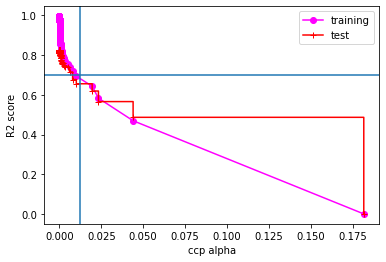

In [94]:
# plotting train score and test score for different trees with different ccp alpha values 

train_score = [reg.score(X_train, y_train) for reg in alpha_list]
test_score = [reg.score(X_test, y_test) for reg in alpha_list]

plt.xlabel("ccp alpha")
plt.ylabel("R2 score")

plt.plot(ccp_alphas, train_score, marker='o', color='magenta', label='training')
plt.plot(ccp_alphas, test_score, marker='+', color='red', label='test', drawstyle='steps-post')
plt.axvline(0.0125)
plt.axhline(0.7)
plt.legend()
plt.show()

>  Possible values of ccp alpha values which is in line with both training and test set lies between 0 and 0.025 that gives around 80% of R2 score.

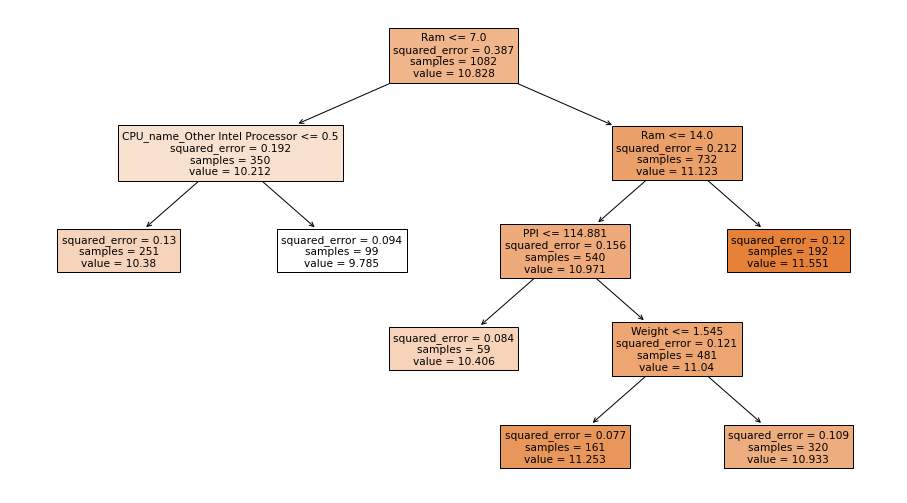

In [95]:
# plotting a decision tree with one of choosen value above

reg = DecisionTreeRegressor(random_state=0, ccp_alpha=0.0085)
reg.fit(X_train, y_train)
plt.figure(figsize=(16,9))
tree.plot_tree(reg, filled=True, feature_names=X_train.columns)
plt.show()

**Now the pruned decision tree is better and simple than previous overfitted tree. Here we just tuned only one hyperparameter. Now we will try with multiple paramteres using randomized Search Cross validation function**

In [96]:
# tuning multiple hyper paramaters 

params=  {
    
    'RandomForest':{
        'model' : RandomForestRegressor(),
        'params':{
            'n_estimators':[int(x) for x in np.linspace(100,1200,10)],
            'criterion':["mse", "mae"],
            'max_depth':[int(x) for x in np.linspace(1,30,5)],
            'max_features':['auto','sqrt','log2'],
            'ccp_alpha':[x for x in np.linspace(0.0025,0.0125,5)],
            'min_samples_split':[2,5,10,14],
            'min_samples_leaf':[2,5,10,14],
        }
    },
    'Decision Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'criterion':["mse", "mae"],
            'max_depth':[int(x) for x in np.linspace(1,30,5)],
            'max_features':['auto','sqrt','log2'],
            'ccp_alpha':[x for x in np.linspace(0.0025,0.0125,5)],
            'min_samples_split':[2,5,10,14],
            'min_samples_leaf':[2,5,10,14],
        }
    }
}

In [97]:
for i, j in params.items():
    print(i, j)

RandomForest {'model': RandomForestRegressor(), 'params': {'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'criterion': ['mse', 'mae'], 'max_depth': [1, 8, 15, 22, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': [0.0025, 0.005, 0.0075, 0.01, 0.0125], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [2, 5, 10, 14]}}
Decision Tree {'model': DecisionTreeRegressor(), 'params': {'criterion': ['mse', 'mae'], 'max_depth': [1, 8, 15, 22, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': [0.0025, 0.005, 0.0075, 0.01, 0.0125], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [2, 5, 10, 14]}}


In [98]:
# training the above params 

scores = []

for model_name, mp in params.items():
    clf = RandomizedSearchCV(mp['model'],
                            param_distributions=mp['params'], cv=5, n_iter=10, scoring='neg_mean_squared_error', verbose=2)
    clf.fit(X_train, y_train)
    scores.append(
    {'model_name': model_name,
    'best_score': clf.best_score_,
    'best_estimator': clf.best_estimator_
    })
    

    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=344; total time=   2.4s
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=344; total time=   2.4s
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=344; total time=   2.5s
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=344; total time=   2.3s
[CV] END ccp_alpha=0.005, criterion=mae, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=344; total time=   2.4s
[CV] END ccp_alpha=0.0025, criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=833; total time=   4.6s
[CV] END ccp_alpha=0.0025

[CV] END ccp_alpha=0.0025, criterion=mse, max_depth=22, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0025, criterion=mse, max_depth=22, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0025, criterion=mse, max_depth=22, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0025, criterion=mse, max_depth=22, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0025, criterion=mse, max_depth=22, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0125, criterion=mae, max_depth=8, ma

In [99]:
scores

[{'model_name': 'RandomForest',
  'best_score': -0.06989491686276438,
  'best_estimator': RandomForestRegressor(ccp_alpha=0.0025, criterion='mae', max_depth=15,
                        min_samples_leaf=2, min_samples_split=5,
                        n_estimators=588)},
 {'model_name': 'Decision Tree',
  'best_score': -0.09173795613099749,
  'best_estimator': DecisionTreeRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=22,
                        max_features='auto', min_samples_leaf=5)}]

**The MSE score is negative as it negative error, it is considered as positive so the score of 0.08 is very good metric**

In [100]:
scores_df = pd.DataFrame(scores, columns=['model_name', 'best_score', 'best_estimator'])
scores_df

model_name  best_score  \
0   RandomForest   -0.069895   
1  Decision Tree   -0.091738   

                                      best_estimator  
0  (DecisionTreeRegressor(ccp_alpha=0.0025, crite...  
1  DecisionTreeRegressor(ccp_alpha=0.0025, criter...

In [101]:
# building the above best model again 

rf = RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=15,
                        min_samples_leaf=10, min_samples_split=10,
                        n_estimators=955)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.r2_score(y_test, y_pred))

0.7882447949686535


> Our previous model gave 89% of R2 score which is better than tuned model, so we will choose the previous model for deployment

#### Prediction on whole dataset 

In [102]:
X.shape

(1274, 39)

In [103]:
final_model = RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=8,
                        max_features='log2', min_samples_leaf=2,
                        min_samples_split=5, n_estimators=344)
final_model.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.0025, criterion='mse', max_depth=8,
                      max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=344)

In [104]:
predictions = np.array(final_model.predict(X))
predictions

array([11.15094305, 10.97901921, 10.71029164, ..., 11.45650053,
        9.82562217, 10.46891805])

In [105]:
# converting predicted values back to Rupees as we transformed them into log values

predictions = np.exp(predictions)

In [106]:
predictions

array([69629.46095928, 58631.02108961, 44814.70682657, ...,
       94513.74311276, 18501.77907051, 35204.10768376])

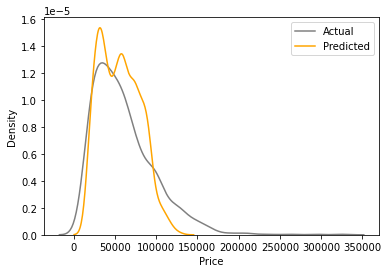

In [107]:
# plotting original and predicted price 

sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(predictions, color='orange', hist=False, label='Predicted')
plt.legend()
plt.show()

> Based on above comparison, we could see that predicted value graph stopped at 150000 INR, so it cannot be the best model 

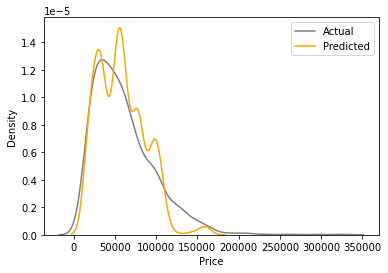

In [108]:
pred = np.exp(rf.predict(X))
sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(pred, color='orange', hist=False, label='Predicted')
plt.legend()
plt.show()

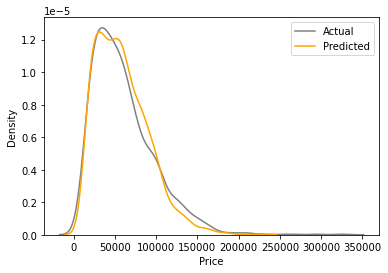

In [109]:
rf1 = RandomForestRegressor(n_estimators=100,
                           random_state=3,
                           max_samples=0.5,
                           max_features=0.75,
                           max_depth=15)
rf1.fit(X_train, y_train)
pred = np.exp(rf1.predict(X))
sns.distplot(df['Price'], color='grey', hist=False, label='Actual')
sns.distplot(pred, color='orange', hist=False, label='Predicted')
plt.legend()

plt.show()

In [110]:
rf1.score(X_test, y_test)

0.8853721686902494

In [111]:
rf1.score(X_train, y_train)

0.9489350998244881

In [112]:
# saving above model in pickle

file = open('laptop_predictor.pkl', 'wb')
pickle.dump(rf1, file)
file.close()

## The End

Random Forest model is well suited for this dataset, but adding some more data or trying different methods of feature engineering based on domain expertise would help increasing the accuracy of the model and its predictions.

Our model has some error which is seen in Mean absolute error and Root mean squared error, so the predictions are off by some 1000 Rupees up and down from the actual price.